In [7]:
import pandas as pd
import numpy as np
import pandas as pd
import nltk
import re
import swifter  # Parallel processing
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')


[nltk_data] Downloading package punkt to
[nltk_data]     /data/home/eey254/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /data/home/eey254/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /data/home/eey254/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /data/home/eey254/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
# Load dataset 
wasabi_data = pd.read_csv("Wasabi_data_themes_genre_mft_updated.csv", low_memory=False) 

# Sentiment Analysis - VADER

In [9]:
def clean_lyrics(text):
    """ Clean and preprocess lyrics. """
    if isinstance(text, str):
        text = text.lower()  # Lowercasing
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
        tokens = word_tokenize(text)  # Tokenization
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]  # Lemmatization
        return ' '.join(lemmatized_tokens)
    return ""

# Minimal preprocessing function for VADER
def preprocess_for_vader(text):
    """Prepares text for VADER sentiment analysis without over-cleaning."""
    if isinstance(text, str):
        text = text.lower().strip()  # Lowercase and remove leading/trailing spaces
        text = re.sub(r'\s+', ' ', text)  # Remove excessive whitespace
        return text
    return ""
   

In [10]:
# Initialize processing tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
sia = SentimentIntensityAnalyzer()

# Apply preprocessing
wasabi_data['processed_lyrics'] = wasabi_data['lyrics'].astype(str).swifter.apply(preprocess_for_vader)


# Function to extract sentiment scores
def get_sentiment(text):
    """Extracts VADER sentiment scores."""
    scores = sia.polarity_scores(text) if isinstance(text, str) else {"compound": 0, "pos": 0, "neg": 0, "neu": 0}
    return scores

# Apply function in parallel using swifter
sentiment_df = wasabi_data['processed_lyrics'].astype(str).swifter.apply(get_sentiment)

# Convert results to DataFrame & Merge
sentiment_df = pd.DataFrame(sentiment_df.tolist()).fillna(0)
wasabi_data = pd.concat([wasabi_data, sentiment_df], axis=1)


In [22]:
# Download the NRC Emotion lexicon: https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm
nrc_file = "NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"

In [25]:
import pandas as pd
import re
import nltk
import swifter
from nltk.tokenize import word_tokenize
from collections import defaultdict

# Download necessary NLTK resources
nltk.download('punkt')

# Minimal preprocessing function (without nltk)
def preprocess_for_nrc(text):
    """Prepares text for NRC Emotion Analysis using simple tokenization."""
    if isinstance(text, str):
        text = text.lower().strip()  # Lowercase and remove leading/trailing spaces
        text = re.sub(r'\s+', ' ', text)  # Remove excessive whitespace
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        return text
    return ""

# Apply preprocessing
wasabi_data['cleaned_lyrics'] = wasabi_data['lyrics'].astype(str).swifter.apply(preprocess_for_nrc)

# Load NRC Emotion Lexicon
nrc_lexicon = defaultdict(set)
with open(nrc_file, "r") as f:
    for line in f:
        word, emotion, score = line.strip().split("\t")
        if int(score) == 1:
            nrc_lexicon[emotion].add(word)  # Group words by emotion for faster lookup

# Function to extract NRC emotion scores (Manual Tokenization)
def extract_nrc_emotions(text):
    """Counts occurrences of NRC emotion words using set lookups (manual tokenization)."""
    emotion_counts = {emotion: 0 for emotion in nrc_lexicon.keys()}  # Initialize emotion scores
    tokens = set(text.split())  # Manual tokenization using simple split()
    for emotion, words in nrc_lexicon.items():
        emotion_counts[emotion] = len(tokens & words)  # Fast set intersection
    return emotion_counts

# Apply function in parallel using swifter
emotion_df = wasabi_data['cleaned_lyrics'].swifter.apply(lambda x: extract_nrc_emotions(x))

# Convert results to DataFrame & Merge
emotion_df = pd.DataFrame(emotion_df.tolist()).fillna(0)
wasabi_data = pd.concat([wasabi_data, emotion_df], axis=1)


[nltk_data] Downloading package punkt to
[nltk_data]     /data/home/eey254/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Pandas Apply: 100%|██████████| 377812/377812 [00:18<00:00, 20426.18it/s]


In [29]:
wasabi_data[['trust', 'fear', 'negative', 'sadness', 'anger', 'surprise', 'positive',
       'disgust', 'joy', 'anticipation']].describe()

,trust,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation
count,377812.000000,377812.000000,377812.000000,377812.000000,377812.000000,377812.000000,377812.000000,377812.000000,377812.000000,377812.000000
mean,3.639665,3.497626,6.077983,3.394672,2.934152,1.981954,6.338909,2.065586,3.589507,3.660628
std,3.162325,3.593772,5.760477,2.975455,3.273908,1.894919,4.888595,2.402876,2.685450,2.806366
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000,3.000000,1.000000,2.000000,2.000000
50%,3.000000,3.000000,5.000000,3.000000,2.000000,2.000000,5.000000,1.000000,3.000000,3.000000
75%,5.000000,5.000000,8.000000,5.000000,4.000000,3.000000,8.000000,3.000000,5.000000,5.000000
max,67.000000,69.000000,98.000000,53.000000,49.000000,25.000000,105.000000,51.000000,46.000000,49.000000


In [26]:
# wasabi_data.to_csv('Wasabi_data_themes_genre_mft_updated.csv', index =None)

## NRC VAD Lexicon

In [3]:

#Load NRC-VAD lexicon
# Get VAD Lexicon here:https://saifmohammad.com/WebPages/nrc-vad.html
nrc_vad_lexicon = pd.read_csv("VAD-based-on-NRC-Lexicon/code/lexicons/NRC-VAD-Lexicon.csv")

# Convert words to lowercase for uniformity
nrc_vad_lexicon['word'] = nrc_vad_lexicon['word'].str.lower()

# Convert NRC-VAD data into a dictionary for fast lookup
nrc_vad_dict = {row['word']: {'valence': row['valence'], 'arousal': row['arousal'], 'dominance': row['dominance']} 
                for _, row in nrc_vad_lexicon.iterrows()}

# Function to preprocess lyrics (remove punctuation, lowercase)
def preprocess_lyrics(text):
    if isinstance(text, str):
        text = text.lower().strip()  # Lowercase
        text = re.sub(r'\s+', ' ', text)  # Remove excessive spaces
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        return text
    return ""

# Apply preprocessing
wasabi_data['processed_lyrics'] = wasabi_data['lyrics'].astype(str).swifter.apply(preprocess_lyrics)

# Function to calculate NRC-VAD scores for each song
def calculate_vad_scores(text):
    words = text.split()  # Tokenize by simple split()
    valence, arousal, dominance, count = 0, 0, 0, 0

    for word in words:
        if word in nrc_vad_dict:  # Check if word exists in NRC-VAD
            valence += nrc_vad_dict[word]['valence']
            arousal += nrc_vad_dict[word]['arousal']
            dominance += nrc_vad_dict[word]['dominance']
            count += 1

    # Compute averages (avoid division by zero)
    return {
        'nrc_valence': valence / count if count > 0 else np.nan,
        'nrc_arousal': arousal / count if count > 0 else np.nan,
        'nrc_dominance': dominance / count if count > 0 else np.nan
    }

# Apply function in parallel using swifter
vad_scores_df = wasabi_data['processed_lyrics'].swifter.apply(lambda x: calculate_vad_scores(x))

# Convert to DataFrame & Merge
vad_scores_df = pd.DataFrame(vad_scores_df.tolist()).fillna(0)
wasabi_data = pd.concat([wasabi_data, vad_scores_df], axis=1)

# View Results
wasabi_data.head()


# Lyrics Embeddings 

### Starting with BERT:

Since traditional lexical features (NRC, ANEW, LIWC) rely on predefined word lists, they miss subtle relationships in meaning.

To capture deeper semantics, we will extract dense embeddings using:

- BERT-based embeddings (SBERT or DistilBERT) → Context-aware sentence embeddings


### Why Use Lyrics Embeddings?
Advantages of Dense Representations:

- ***BERT (Sentence-Level Embeddings):*** Captures meaning beyond individual words, useful for analyzing context & relationships.

- ***Word2Vec (Word-Level Embeddings):*** Finds similar words based on co-occurrence patterns, useful for semantic analysis.
- ***Better for Regression & Clustering:*** Traditional lexicons are sparse, whereas embeddings provide continuous numerical representations.


In [6]:
# !pip install torch transformers sentence-transformers gensim nltk

In [53]:
# !pip uninstall numpy scipy gensim -y
# !pip install numpy scipy gensim

In [8]:
wasabi_data.shape

(377812, 111)

In [2]:
import torch
import gensim
import nltk
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from gensim.models import Word2Vec

In [12]:
# Ensure necessary NLTK downloads
nltk.download('punkt')

# # Uncoment the code below if you haven't preprocessed the lyrics yet (clean text for embeddings):
# def preprocess_lyrics(text):
#     """Cleans lyrics for embeddings processing."""
#     if isinstance(text, str):
#         text = text.lower().strip()  # Lowercase
#         text = re.sub(r'\s+', ' ', text)  # Remove excessive spaces
#         text = re.sub(r'\d+', '', text)  # Remove numbers
#         text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
#         return text
#     return ""

# # Apply preprocessing
# wasabi_data['processed_lyrics'] = wasabi_data['lyrics'].astype(str).swifter.apply(preprocess_lyrics)

# Extract SBERT (DistilBERT) Embeddings
print("Loading SBERT Model...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')  # Efficient BERT variant

def get_sbert_embedding(text):
    """Computes SBERT embedding for lyrics."""
    return sbert_model.encode(text).tolist()  # Convert numpy array to list

# Apply SBERT function
print("Extracting SBERT embeddings...")
wasabi_data['sbert_embedding'] = wasabi_data['processed_lyrics'].swifter.apply(get_sbert_embedding)

In [14]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /data/home/eey254/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [10]:
wasabi_data['sbert_embedding']

0         [-0.019254934042692184, 0.061234571039676666, ...
1         [-0.03193764016032219, 0.032371893525123596, 0...
2         [-0.06061520427465439, -0.06362481415271759, 0...
3         [-0.09493272006511688, -0.05648251250386238, 0...
4         [-0.06524080038070679, 0.011746851727366447, 0...
                                ...                        
377807    [0.04207802191376686, -0.04918871447443962, -0...
377808    [0.059777624905109406, -0.08298368006944656, 0...
377809    [-0.006526113022118807, -0.0253498125821352, 0...
377810    [0.028200434520840645, -0.045501917600631714, ...
377811    [-0.023570707067847252, -0.02721540443599224, ...
Name: sbert_embedding, Length: 377812, dtype: object

### Cosine Similarity of songs for Lyrics similarity (mainstreamness):

In [50]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Extract embeddings from dataset
embeddings_matrix = np.array(wasabi_data['sbert_embedding'].tolist())

# Step 1: Apply PCA to Reduce Embedding Dimensions
pca = PCA(n_components=50)  # Reduce embeddings to 50 principal components
pca_embeddings = pca.fit_transform(embeddings_matrix)

# Step 2: Select 100 Random Reference Songs
np.random.seed(42)  # For reproducibility
random_indices = np.random.choice(len(pca_embeddings), size=10000, replace=False)
reference_embeddings = pca_embeddings[random_indices]

# Step 3: Compute Cosine Similarity for Each Song Against Reference Songs
similarity_scores = cosine_similarity(pca_embeddings, reference_embeddings)

# Step 4: Compute Average Similarity Score (Mainstream-ness Indicator)
wasabi_data['lyrics_similarity_score'] = similarity_scores.mean(axis=1)


In [51]:
wasabi_data[['lyrics_similarity_score']].describe()

,lyrics_similarity_score
count,377812.000000
mean,0.000380
std,0.005353
min,-0.015692
25%,-0.003496
50%,0.000501
75%,0.004389
max,0.015086


In [55]:
!pip install faiss-cpu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 73.4 MB/s eta 0:00:00:00:01


In [56]:
import faiss
from sklearn.decomposition import PCA

# Similarity Scores using Facebook AI Similarity Score (FAISS)

In [111]:
len(wasabi_data['word2vec_embedding'][1])

300

In [113]:
#Step 1: Convert SBERT embeddings from list format to numpy array
embeddings_matrix = np.array(wasabi_data['sbert_embedding'].tolist()).astype(np.float32)

# Step 2: Build FAISS Index for Approximate Similarity
d = embeddings_matrix.shape[1]  # Number of dimensions (without PCA)
index = faiss.IndexFlatL2(d)  # L2 distance (Euclidean) index
index.add(embeddings_matrix)  # Add full embeddings

# Step 3: Compute Similarity for Each Song (Find k Nearest Neighbors)
k = 10  # Number of nearest neighbors to consider
_, nearest_neighbors = index.search(embeddings_matrix, k)

# Step 4: Compute Average Similarity Score for Each Song
def compute_avg_similarity(song_idx, neighbors):
    return np.mean([
        np.linalg.norm(embeddings_matrix[song_idx] - embeddings_matrix[n]) 
        for n in neighbors if n != song_idx
    ])

wasabi_data['lyrics_similarity_score'] = [
    compute_avg_similarity(i, nearest_neighbors[i]) for i in range(len(embeddings_matrix))]


In [115]:
wasabi_data[['lyrics_similarity_score']].describe()

,lyrics_similarity_score
count,377812.000000
mean,0.763069
std,0.145627
min,0.000000
25%,0.715607
50%,0.785275
75%,0.848523
max,1.227407


In [120]:
moral_columns = ['care', 'harm', 'fairness', 'cheating', 'loyalty', 'betrayal', 
                 'authority', 'subversion', 'purity', 'degradation']

# Compute average similarity score per moral
moral_similarity_scores = wasabi_data[moral_columns].multiply(wasabi_data['lyrics_similarity_score'], axis=0).sum() / wasabi_data[moral_columns].sum()

# Convert to DataFrame for visualization
moral_similarity_df = moral_similarity_scores.reset_index()
moral_similarity_df.columns = ["Genre", "Average Lyrics Similarity"]

In [121]:
moral_similarity_df

,Genre,Average Lyrics Similarity
0,care,0.737512
1,harm,0.767183
2,fairness,0.768579
3,cheating,0.774953
4,loyalty,0.754314
5,betrayal,0.756089
6,authority,0.769634
7,subversion,0.780150
8,purity,0.756380
9,degradation,0.784783


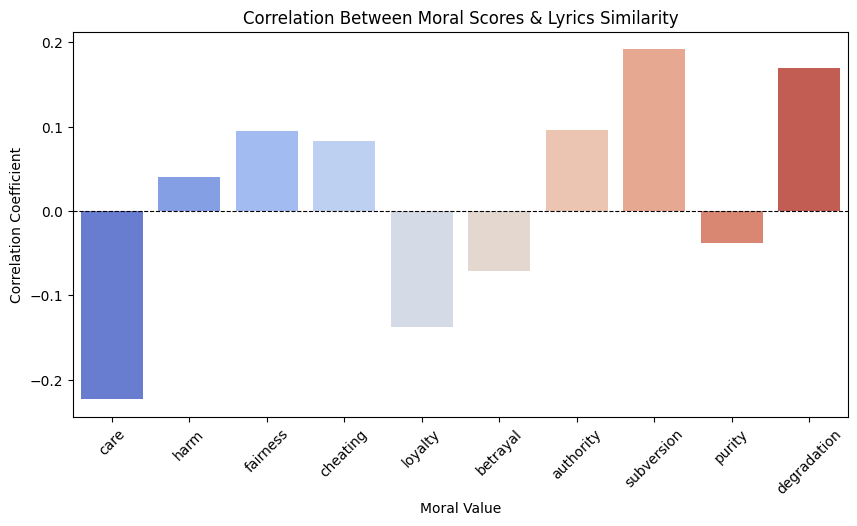

In [122]:
# Compute Correlation Between Similarity Score & Moral Scores
moral_columns = ['care', 'harm', 'fairness', 'cheating', 'loyalty', 'betrayal', 
                 'authority', 'subversion', 'purity', 'degradation']

# Compute correlations
correlation_matrix = wasabi_data[moral_columns + ['lyrics_similarity_score']].corr()

# Extract correlations between moral scores & similarity score
moral_similarity_correlation = correlation_matrix.loc['lyrics_similarity_score', moral_columns]

# Convert to DataFrame for better visualization
moral_similarity_df = moral_similarity_correlation.reset_index()
moral_similarity_df.columns = ["Moral Value", "Correlation with Similarity Score"]

# Visualize Correlation Between Lyrics Similarity & Moral Values
plt.figure(figsize=(10, 5))
sns.barplot(data=moral_similarity_df, x="Moral Value", y="Correlation with Similarity Score", palette="coolwarm")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a reference line at 0
plt.xticks(rotation=45)
plt.ylabel("Correlation Coefficient")
plt.title("Correlation Between Moral Scores & Lyrics Similarity")
plt.show()
